In [ ]:
!git clone https://github.com/chengjiali/Prompt-Transferability.git
%cd Prompt-Transferability
!pip install -r requirements.txt

Cloning into 'Prompt-Transferability'...
remote: Enumerating objects: 12701, done.
remote: Counting objects: 100% (472/472), done.
remote: Compressing objects: 100% (232/232), done.
remote: Total 12701 (delta 239), reused 458 (delta 236), pack-reused 12229
Receiving objects: 100% (12701/12701), 644.51 MiB | 22.51 MiB/s, done.
Resolving deltas: 100% (6667/6667), done.
/content/Prompt-Transferability
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.4/146.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.3 MB/s eta 0:00:00


In [ ]:
pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.9.0+cu111 (from versions: 1.11.0, 1.11.0+cpu, 1.11.0+cu102, 1.11.0+cu113, 1.11.0+cu115, 1.11.0+rocm4.3.1, 1.11.0+rocm4.5.2, 1.12.0, 1.12.0+cpu, 1.12.0+cu102, 1.12.0+cu113, 1.12.0+cu116, 1.12.0+rocm5.0, 1.12.0+rocm5.1.1, 1.12.1, 1.12.1+cpu, 1.12.1+cu102, 1.12.1+cu113, 1.12.1+cu116, 1.12.1+rocm5.0, 1.12.1+rocm5.1.1, 1.13.0, 1.13.0+cpu, 1.13.0+cu116, 1.13.0+cu117, 1.13.0+cu117.with.pypi.cudnn, 1.13.0+rocm5.1.1, 1.13.0+rocm5.2, 1.13.1, 1.13.1+cpu, 1.13.1+cu116, 1.13.1+cu117, 1.13.1+cu117.with.pypi.cudnn, 1.13.1+rocm5.1.1, 1.13.1+rocm5.2, 2.0.0, 2.0.0+cpu, 2.0.0+cpu.cxx11.abi, 2.0.0+cu117, 2.0.0+cu117.with.pypi.cudnn, 2.0.0+cu118, 2.0.0+rocm5.3, 2.0.0+rocm5.4.2, 2.0.1, 2.0.1+cpu, 2.0.1+cpu.cxx11.abi, 2.0.1+cu117, 2.0.1+cu117.with.pypi.cudnn, 2.0.1+cu118, 2.0.1+rocm5.3, 2.0.1+rocm5.4.2, 2.1.0, 2.1.0+cpu, 2.1.0+cpu.cxx11.abi, 2.1.0+cu118, 2.1.0+cu121, 2.

In [ ]:
%cd Prompt-Transferability-2.0-latest/

/content/Prompt-Transferability/Prompt-Transferability-2.0-latest


In [ ]:
import json
import os
import sys
import torch
import logging
import random
import numpy as np

from datasets import load_dataset, load_metric
from transformers.trainer_utils import get_last_checkpoint
from transformers import (
    set_seed,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EvalPrediction,
    default_data_collator,
)
from openprompt.data_utils.utils import InputExample
from openprompt import PromptDataLoader, PromptForClassification
from openprompt.plms import load_plm
from openprompt.prompts import SoftTemplate, ManualVerbalizer

from prompt_hub import task_to_keys, get_model
from prompt_hub.hub import PromptHub
from prompt_hub.training_args import PromptTrainingArguments, RemainArgHfArgumentParser

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


## Train prompt

Let's first generate a config and convert it into `huggingface.TrainingArguments`.

In [ ]:
config = {
    "do_train": True,
    "do_eval": True,
    "do_test": True,
    "prompt_len": 100,
    "num_proj_layers": 1,
    "flatten_proj": True,
    "max_steps": 100,
    "eval_steps": 10,
    "save_steps": 10,
    "logging_steps": 2,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 128,
    "learning_rate": 5e-4,
    "lr_scheduler_type": 'constant',
    "warmup_steps": 0,

    "save_total_limit": 1,
    "predict_with_generate": True,
    "load_best_model_at_end": True,
    "metric_for_best_model": "combined_score",
    "greater_is_better": True,
    "evaluation_strategy": "steps",
    "overwrite_output_dir": True,
    "save_strategy": "steps",
    "model_parallel": False
}

args = PromptTrainingArguments(
    output_dir='outputs',
    backbone='roberta-base',
    dataset='sst2',
    prompt_len=100
)

for k, v in config.items():
  setattr(args, k, v)

In [ ]:
set_seed(args.seed)

is_regression = args.dataset in ['stsb']

metric = load_metric("prompt_hub/glue_metrics.py", args.dataset)

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)
    result = metric.compute(predictions=preds, references=p.label_ids)
    result["combined_score"] = np.mean(list(result.values())).item()

    return result

<ipython-input-8-c008a5d53d4d>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("prompt_hub/glue_metrics.py", args.dataset)


In [ ]:
trainer = PromptHub(
    args=args,
    compute_metrics=compute_metrics,
)

Trainable parameters:
prompt_model.template.soft_embeds torch.Size([100, 768])
Template: SoftTemplate(
  (raw_embedding): Embedding(50265, 768, padding_idx=1)
)
Verbalizer: ManualVerbalizer()
Raw input example: {
  "guid": 0,
  "label": 0,
  "meta": {},
  "text_a": "hide new secretions from the parental units ",
  "text_b": "",
  "tgt_text": null
}

Wrapped input example: [[{'text': '', 'loss_ids': 0, 'shortenable_ids': 0}, {'text': '<mask>', 'loss_ids': 1, 'shortenable_ids': 0}, {'text': ' hide new secretions from the parental units ', 'loss_ids': 0, 'shortenable_ids': 1}, {'text': ' ', 'loss_ids': 0, 'shortenable_ids': 1}], {'guid': 0, 'label': 0}]


#### Train Prompt

To save time, we use a pretrained prompt.

In [ ]:
trainer.train_prompt(args.backbone, args.dataset)

tokenizing: 67349it [00:39, 1717.79it/s]


Step,Training Loss,Validation Loss,Accuracy,Combined Score
10,0.595900,0.642534,61.009174,61.009174
20,0.638600,0.606903,64.564220,64.564220
30,0.702200,0.616886,63.990826,63.990826
40,0.517400,0.600775,66.628440,66.628440
50,0.563700,0.529814,74.655963,74.655963
60,0.481600,0.515125,77.064220,77.064220
70,0.601600,0.499464,78.211009,78.211009
80,0.504700,0.493227,78.440367,78.440367
90,0.396300,0.526522,74.541284,74.541284
100,0.510000,0.499964,77.408257,77.408257


tokenizing: 872it [00:00, 1649.75it/s]
tokenizing: 872it [00:00, 1121.94it/s]
tokenizing: 872it [00:00, 1844.67it/s]
tokenizing: 872it [00:00, 1809.08it/s]
tokenizing: 872it [00:00, 1423.71it/s]
tokenizing: 872it [00:00, 1804.28it/s]
tokenizing: 872it [00:00, 1514.70it/s]
tokenizing: 872it [00:00, 1753.85it/s]
tokenizing: 872it [00:00, 1847.72it/s]
tokenizing: 872it [00:00, 1066.43it/s]
There were missing keys in the checkpoint model loaded: ['prompt_model.plm.roberta.embeddings.word_embeddings.weight', 'prompt_model.plm.roberta.embeddings.position_embeddings.weight', 'prompt_model.plm.roberta.embeddings.token_type_embeddings.weight', 'prompt_model.plm.roberta.embeddings.LayerNorm.weight', 'prompt_model.plm.roberta.embeddings.LayerNorm.bias', 'prompt_model.plm.roberta.encoder.layer.0.attention.self.query.weight', 'prompt_model.plm.roberta.encoder.layer.0.attention.self.query.bias', 'prompt_model.plm.roberta.encoder.layer.0.attention.self.key.weight', 'prompt_model.plm.roberta.encoder.l

TrainOutput(global_step=100, training_loss=0.5242849373817444, metrics={'train_runtime': 207.8607, 'train_samples_per_second': 7.697, 'train_steps_per_second': 0.481, 'total_flos': 0.0, 'train_loss': 0.5242849373817444, 'epoch': 0.02})

#### Evaluate Prompt

Now we can evaluate the trained prompt.

In [ ]:
eval_results = trainer.eval_prompt(args.backbone, args.dataset)
print(eval_results)

tokenizing: 872it [00:00, 1745.79it/s]


{'eval_loss': 0.49322667717933655, 'eval_accuracy': 78.44036697247707, 'eval_combined_score': 78.44036697247707, 'eval_runtime': 14.4852, 'eval_samples_per_second': 7.732, 'eval_steps_per_second': 0.069, 'epoch': 0.02}


#### Cross-Model training and evaluation

Now let's do a cross-model training and evaluation. We transfer the prompt trained on `robert-base` onto `roberta-large`. In order to save time, we use a pretrained projector.

In the following example, we get a `73.17%` relative performance.

In [ ]:
trainer.cross_model_train(source_model=args.backbone, target_model='roberta-large', task=args.dataset)
cross_model_eval_results = trainer.cross_model_eval(source_model=args.backbone, target_model='roberta-large', task=args.dataset)
print(cross_model_eval_results)

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Trainable parameters:
prompt_model.template.proj.0.weight torch.Size([768, 76800])
prompt_model.template.proj.0.bias torch.Size([768])
prompt_model.template.proj.2.weight torch.Size([102400, 768])
prompt_model.template.proj.2.bias torch.Size([102400])


tokenizing: 67349it [00:37, 1793.74it/s]


Step,Training Loss,Validation Loss


tokenizing: 872it [00:00, 1588.54it/s]


RuntimeError: ignored

#### Activated neuron

With the trained prompt, we can investigate the activated neurons of the PLM.

In [ ]:
activated_neuron_before_relu, activated_neuron_after_relu = trainer.activated_neuron(args.backbone, args.dataset)

#### Mask neuron

We show that masking `20%` of important neurons, the model's performance significantly degradates.

In [ ]:
trainer.mask_activated_neuron(args.backbone, args.dataset, ratio=0.2)

{'eval_loss': 2.024170398712158, 'eval_accuracy': 34.82142857142857, 'eval_combined_score': 34.82142857142857, 'eval_runtime': 23.2738, 'eval_samples_per_second': 52.935, 'eval_steps_per_second': 0.43}


#### Plot neuron

Text(339.0, 0.5, 'Layer')

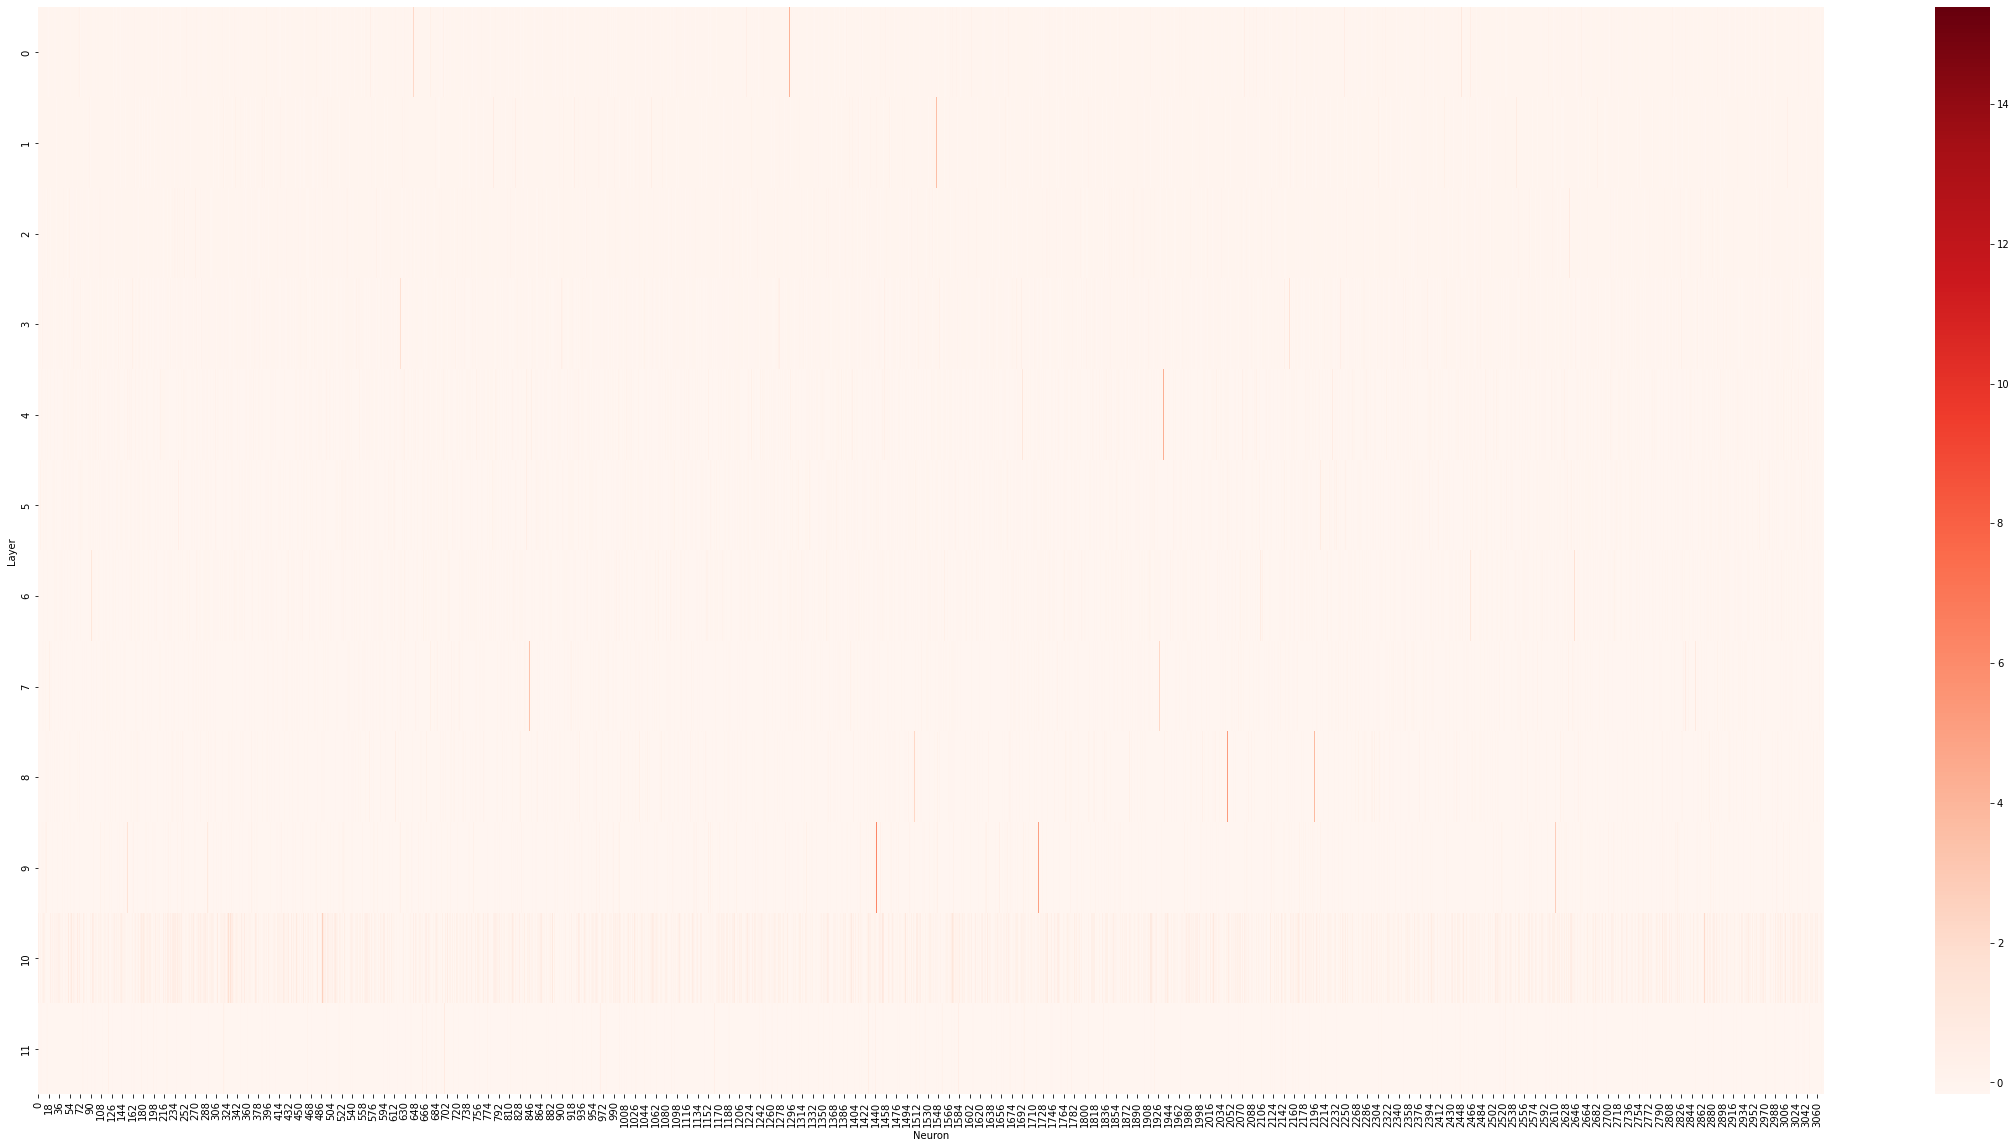

In [ ]:
trainer.plot_neuron()